In [1]:
import matplotlib.pyplot as plt 
from scipy.io import readsav
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from matplotlib import colors
import cmasher as cmr
import sunpy.cm as cm #The functionality of the sunpy.cm module is now in sunpy.visualization.colormaps as of SunPy 1.1
from tqdm import tqdm
from helita.io import lp
import COCOpy as cp
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
import matplotlib as mpl
from scipy import ndimage
import COCOpy as cp
import time
import multiprocessing as mp

In [2]:
dpath_SST = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/'
dpath_SST_processed = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/'
dpath_EDVARDA_SDO = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo2sst/' 
dpath_SDO_BOSE ='/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/SDO_only_aia/'
sdo_target_cubes = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo/target/cubes/'

# SST

In [3]:
# ---- Reduced H-beta data----
hdrH_im =lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
hdrH_sp = lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])

#----- Unsharp masked Dopplergram ----
hdr_dopp = lp.getheader(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_dopp = hdr_dopp[0]
cube_dopp = lp.getdata(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_dopp = np.reshape(cube_dopp,[dim_dopp[0],dim_dopp[1],dim_dopp[2]])

#------- RBE detections --------
hdr_rbe_mask = lp.getheader(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rbe_mask = hdr_rbe_mask[0]
cube_rbe_mask = lp.getdata(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rbe_mask = np.reshape(cube_rbe_mask,[dim_rbe_mask[0],dim_rbe_mask[1],dim_rbe_mask[2]])

#------ RRE detections --------
hdr_rre_mask = lp.getheader(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rre_mask = hdr_rre_mask[0]
cube_rre_mask = lp.getdata(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rre_mask = np.reshape(cube_rre_mask,[dim_rre_mask[0],dim_rre_mask[1],dim_rre_mask[2]])
#cube_dopp=np.swapaxes(cube_dopp,0,1)

#------ Fe I 6173 AA magnetic field------
hdr_mag_los = lp.getheader(dpath_SST+'Blos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
dim_mag_los = hdr_mag_los[0]
cube_mag_los= lp.getdata(dpath_SST+'Blos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
cube_mag_los = np.reshape(cube_mag_los, [dim_mag_los[0],dim_mag_los[1],dim_mag_los[2]])

#------ Fe I 6173 AA LOS velocity field------
hdr_V_los = lp.getheader(dpath_SST+'Vlos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
dim_V_los = hdr_V_los[0]
cube_V_los= lp.getdata(dpath_SST+'Vlos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
cube_V_los = np.reshape(cube_V_los, [dim_V_los[0],dim_V_los[1],dim_V_los[2]])

#------ H-beta 4861.33 AA line-core widths (see Line_widths.ipynb/.py for more details on this) ------
hdr_lc_widths = lp.getheader(dpath_SST+'lc_widths_nb_4846_2021-08-04T09:56:50_scans=0-95.fcube')
dim_lc_widths = hdr_lc_widths[0]
cube_lc_widths = lp.getdata(dpath_SST+'lc_widths_nb_4846_2021-08-04T09:56:50_scans=0-95.fcube')
cube_lc_widths = np.reshape(cube_lc_widths, [dim_lc_widths[0],dim_lc_widths[1],dim_lc_widths[2]])

#----- time and wavelength stamps --------
time_steps = readsav(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im_times+wvl.idlsave')
times = time_steps['times']
wav = time_steps['LAMBDA']

In [22]:
H_avg = np.mean(np.mean(np.mean(cubeH[:,:,:,:],axis=0),axis=0),axis=0)

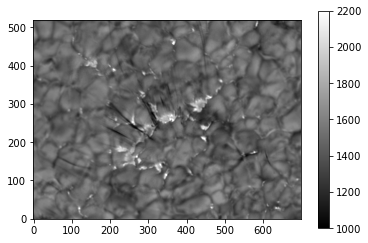

In [10]:
##------- Test display --------
plt.imshow(cubeH[400:1100,600:1120,77,19].T, origin='lower', cmap='gray',vmax=2200,vmin=1000)
plt.colorbar()
# plt.axvline(x=300)
# plt.axvline(x=400)
# plt.axhline(y=260)
# plt.axhline(y=360)

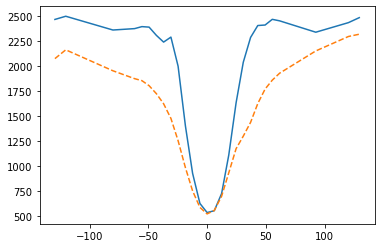

In [24]:
dopp_Hb = ((wav-wav[13])/wav[13])*3e5
plt.plot(dopp_Hb,cubeH[671,764,77,:])
plt.plot(dopp_Hb, H_avg, linestyle='dashed')

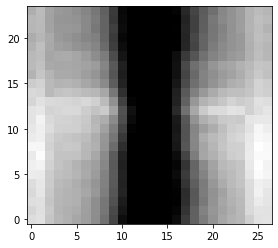

In [52]:
plt.imshow(cubeH[671,764,65:89,:],origin='lower',cmap='gray',interpolation='nearest',vmin=800)
#plt.colorbar()

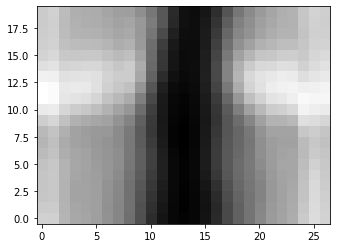

In [44]:
plt.imshow(cubeH[671,750:770,77,:],origin='lower',cmap='gray',interpolation='nearest')